In [1]:
from enstools.io import read
from enstools.plot import contour
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.dates import DateFormatter
import glob
import pandas as pd
import xarray as xr
import numpy as np
import dask
import seaborn as sns
import logging
import cartopy.crs as ccrs
import cartopy.feature as cf
from tqdm import tqdm
from misc_functions import my_contour
from misc_functions import get_radar_mask
from misc_functions import get_prec_time
from misc_functions import compute_theta_v
from misc_functions import get_color_and_lw
from misc_functions import get_data
#dfdf
homedir = '/home/m/M.Hirt/'


plt.style.use(['seaborn-colorblind', '/home/m/M.Hirt/poster.mplstyle'])
#matplotlib widget
logger = logging.getLogger()
logger.setLevel(logging.INFO)





In [2]:
import warnings
warnings.filterwarnings("ignore")

#plt.rcParams['figure.figsize'] = [5,5]

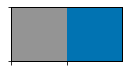

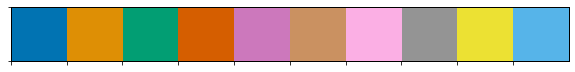

In [3]:
current_palette = sns.color_palette('tab10')
colors =[ sns.color_palette('colorblind')[i] for i in [7,0]]
secondary_colors= sns.color_palette('colorblind')#[sns.color_palette('deep')[i] for i in [3,9,8,2,1,0,4,6,7]]

sns.palplot(colors)
sns.palplot(secondary_colors)

In [58]:
secondary_colors

[(0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
 (0.8705882352941177, 0.5607843137254902, 0.0196078431372549),
 (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.8352941176470589, 0.3686274509803922, 0.0),
 (0.8, 0.47058823529411764, 0.7372549019607844),
 (0.792156862745098, 0.5686274509803921, 0.3803921568627451),
 (0.984313725490196, 0.6862745098039216, 0.8941176470588236),
 (0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.9254901960784314, 0.8823529411764706, 0.2),
 (0.33725490196078434, 0.7058823529411765, 0.9137254901960784)]

In [4]:
fname = '/project/meteo-scratch/Christian.Sackrenz/cpp-new/cpp_a2.0_pt_rho_pert_20160605_lev_45_thres_pt_1.2_thres_rain_max_4.0_mm_h_filter_30_2_px_msize_24_allmod3box.nc'
ds_cpp = read(fname)

fname = '/project/meteo-scratch/Christian.Sackrenz/cpp-new/_pt_rho_pert_20160605_lev_45_thres_pt_1.2_thres_rain_max_4.0_mm_h_filter_30_2_px_msize_24_allmod3box.nc'
ds_ref = read(fname)
ds_ref

<xarray.Dataset>
Dimensions:                (rlat: 461, rlon: 421, time: 25)
Coordinates:
  * time                   (time) datetime64[ns] 2016-06-05 ... 2016-06-06
  * rlat                   (rlat) float32 -5.0 -4.975 -4.95 ... 6.45 6.475 6.5
  * rlon                   (rlon) float32 -5.0 -4.975 -4.95 ... 5.45 5.475 5.5
    lat                    (rlat, rlon) float32 dask.array<shape=(461, 421), chunksize=(461, 421)>
    lon                    (rlat, rlon) float32 dask.array<shape=(461, 421), chunksize=(461, 421)>
Data variables:
    rotated_pole           (time) |S1 dask.array<shape=(25,), chunksize=(25,)>
    indexh                 (time) int64 dask.array<shape=(25,), chunksize=(25,)>
    pt_rho_pert            (time, rlat, rlon) float32 dask.array<shape=(25, 461, 421), chunksize=(25, 461, 421)>
    pt                     (time, rlat, rlon) float32 dask.array<shape=(25, 461, 421), chunksize=(25, 461, 421)>
    pt_rho                 (time, rlat, rlon) float32 dask.array<shape=(25, 4

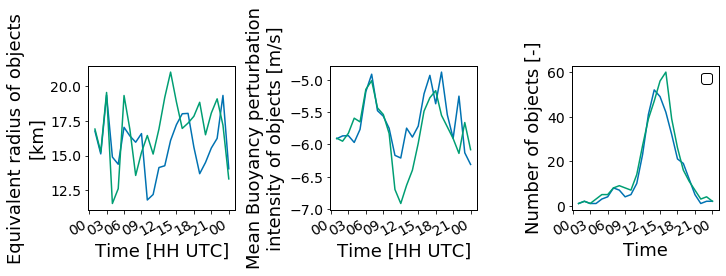

In [6]:
fig, axs = plt.subplots(ncols=3, nrows=1, sharex=True, sharey=False, figsize=[10,3.5])

ds_ref.r_equ_mean.plot(label='reference', ax=axs[0])
ds_cpp.r_equ_mean.plot(label='CPP', ax=axs[0])
plt.legend()

ds_ref.intensity_median.plot(label='reference', ax=axs[1])
ds_cpp.intensity_median.plot(label='CPP', ax=axs[1])
plt.legend()

ds_ref.n_clusters.plot(label='reference', ax=axs[2])
ds_cpp.n_clusters.plot(label='CPP', ax=axs[2])
plt.legend()

for i in range(0,2):
    axs[i].set_xlabel('Time [HH UTC]')
    axs[i].xaxis.set_major_formatter(DateFormatter("%H"))
    #axs[i].autoscale(tight=True)
plt.tight_layout()

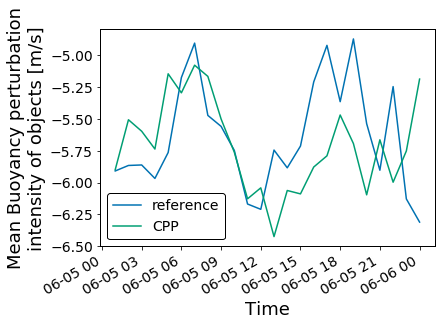

In [12]:
ds_ref.intensity_median.plot(label='reference')
ds_cpp.intensity_median.plot(label='CPP')
plt.legend()

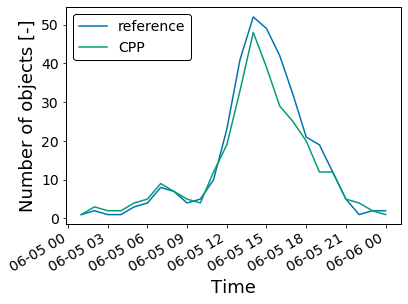

In [13]:
ds_ref.n_clusters.plot(label='reference')
ds_cpp.n_clusters.plot(label='CPP')
plt.legend()

# Data for single cold pool objects

In [7]:
fname = '/project/meteo-scratch/Christian.Sackrenz/cpp-new/datencp_cpp.csv'
df = pd.read_csv(fname)

fname = '/project/meteo/work/M.Hirt/Cold_pool_perturbations/detected_coldpools_CSackrenz/datencp_referenz.csv'
df_ref = pd.read_csv(fname)
df['run']='CPP'
df_ref['run'] ='reference'
df = pd.concat([df, df_ref])


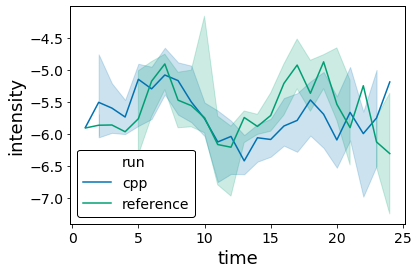

In [15]:
sns.lineplot(data=df, x='time', y = 'intensity', hue='run', estimator=np.median)

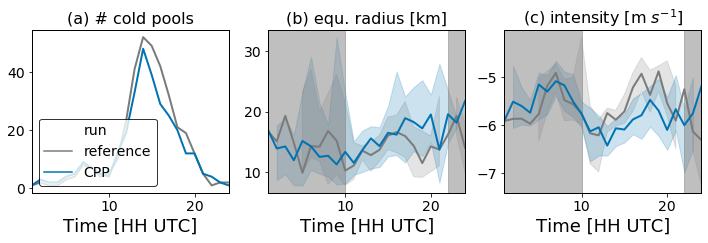

In [17]:
fig, axs = plt.subplots(ncols=3, nrows=1, sharex=False, sharey=False, figsize=[12,3.])

colors =[(0.4803921568627451, 0.4803921568627451, 0.4803921568627451),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745)]

kws =dict(hue_order=['reference', 'CPP'], palette=colors, lw=2)

sns.lineplot(data=df, x='time', y = 'radius_equ',hue='run', estimator=np.count_nonzero, ci=None, ax=axs[0], **kws)
leg = axs[0].legend(loc='lower left' , ncol=1, fontsize=14)
leg.get_frame().set_alpha(0.8)
axs[0].set_title('(a) # cold pools',fontsize=16)

sns.lineplot(data=df, x='time', y = 'radius_equ', hue='run', estimator=np.median,ax=axs[1], legend=False, **kws)
axs[1].axvspan(-2, 10, alpha=0.5, color='grey')
axs[1].axvspan(22, 25, alpha=0.5, color='grey')
axs[1].set_title('(b) equ. radius [km]',fontsize=16)

sns.lineplot(data=df, x='time', y = 'intensity', hue='run', estimator=np.median,ax=axs[2], legend=False, **kws)
axs[2].axvspan(-2, 10, alpha=0.5, color='grey')
axs[2].axvspan(22, 25, alpha=0.5, color='grey')
axs[2].set_title(r'(c) intensity [m $s^{-1}$]',fontsize=16)

for i in range(0,3):
    axs[i].set_xlabel('Time [HH UTC]')
    axs[i].set_xlim([1,24])
    axs[i].set_ylabel('')
#    axs[i].xaxis.set_major_formatter(DateFormatter("%H"))
    #axs[i].autoscale(tight=True)
#plt.tight_layout()
figname='../../Thesis/Figures/CPPERT/detected_coldpools_statistics.pdf'
plt.savefig(figname, bbox_inches='tight')

In [11]:
colors

[(0.5803921568627451, 0.5803921568627451, 0.5803921568627451),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745)]

# Whole period

In [53]:
list_cpp =[]
list_cpp2 =[]
list_ref =[]
for date in tqdm( [ '20160529','20160530','20160531', '20160601', '20160602', '20160603', '20160604', #'20160527', '20160528', , '20160608', '20160609'
            '20160605','20160606', '20160607']): 
    fname = '/project/meteo-scratch/Christian.Sackrenz/cpp-new/cpp_a1.2_pt_rho_pert_'+date+'_lev_45_thres_pt_1.2_thres_rain_max_4.0_mm_h_filter_30_2_px_msize_24_allmod3box.nc'
    egg_cpp = read(fname)
    egg_cpp['start_date'] = egg_cpp.time.isel(time=0).time -np.timedelta64(1,'h') # data starts at 1, not 00 --> subtract 1 hour for start_date
    egg_cpp['leadtime'] = (egg_cpp.time - egg_cpp.start_date)/ np.timedelta64(1,'h')
    egg_cpp = egg_cpp.set_coords(['leadtime', 'start_date'])
    egg_cpp = egg_cpp.swap_dims({'time':'leadtime'})
    list_cpp.append(egg_cpp)
    
    fname = '/project/meteo-scratch/Christian.Sackrenz/cpp-new/cpp_a2.0_pt_rho_pert_'+date+'_lev_45_thres_pt_1.2_thres_rain_max_4.0_mm_h_filter_30_2_px_msize_24_allmod3box.nc'
    egg_cpp = read(fname)
    egg_cpp['start_date'] = egg_cpp.time.isel(time=0).time -np.timedelta64(1,'h') # data starts at 1, not 00 --> subtract 1 hour for start_date
    egg_cpp['leadtime'] = (egg_cpp.time - egg_cpp.start_date)/ np.timedelta64(1,'h')
    egg_cpp = egg_cpp.set_coords(['leadtime', 'start_date'])
    egg_cpp = egg_cpp.swap_dims({'time':'leadtime'})
    list_cpp2.append(egg_cpp)
    

    fname = '/project/meteo-scratch/Christian.Sackrenz/cpp-new/_pt_rho_pert_'+date+'_lev_45_thres_pt_1.2_thres_rain_max_4.0_mm_h_filter_30_2_px_msize_24_allmod3box.nc'
    egg_ref = read(fname)
    egg_ref['start_date'] = egg_ref.time.isel(time=0).time -np.timedelta64(1,'h') # data starts at 1, not 00 --> subtract 1 hour for start_date
    egg_ref['leadtime'] = (egg_ref.time - egg_ref.start_date)/ np.timedelta64(1,'h')
    egg_ref = egg_ref.set_coords(['leadtime', 'start_date'])
    egg_ref = egg_ref.swap_dims({'time':'leadtime'})
    list_ref.append(egg_ref)
    
ds_ref =xr.concat(list_ref, dim ='start_date')
ds_cpp =xr.concat(list_cpp, dim ='start_date')
ds_cpp2 =xr.concat(list_cpp2, dim ='start_date')

ds_cpp['run']='CPPa1.2'
ds_cpp2['run']='CPPa2'
ds_ref['run'] ='reference'
ds = xr.concat([ds_cpp,ds_cpp2, ds_ref], dim='run')

100%|██████████| 10/10 [00:04<00:00,  2.51it/s]


In [48]:
ds

<xarray.Dataset>
Dimensions:                (leadtime: 25, rlat: 461, rlon: 421, run: 2, start_date: 10)
Coordinates:
  * rlat                   (rlat) float32 -5.0 -4.975 -4.95 ... 6.45 6.475 6.5
  * rlon                   (rlon) float32 -5.0 -4.975 -4.95 ... 5.45 5.475 5.5
    lat                    (rlat, rlon) float32 44.76518 44.767513 ... 56.137974
    lon                    (rlat, rlon) float32 2.9758525 ... 19.840677
  * leadtime               (leadtime) float64 1.0 2.0 3.0 4.0 ... 23.0 24.0 25.0
    time                   (start_date, leadtime) datetime64[ns] 2016-05-29 ... 2016-06-08
  * start_date             (start_date) datetime64[ns] 2016-05-28T23:00:00 ... 2016-06-06T23:00:00
  * run                    (run) <U9 'CPP' 'reference'
Data variables:
    rotated_pole           (run, start_date, leadtime) |S1 dask.array<shape=(2, 10, 25), chunksize=(1, 1, 25)>
    indexh                 (run, start_date, leadtime) int64 dask.array<shape=(2, 10, 25), chunksize=(1, 1, 25)>
    p

In [54]:
#ds
egg = ds[['r_equ_mean','area_mean', 'n_clusters','pt_rho_pert_mean', 'pt_rho_pert_max', 'qv_pert_mean', 'intensity_median']]
df = egg.to_dataframe().reset_index()
df['forcing_type']=None
df.loc[df.start_date<'2016-06-03', 'forcing_type']='strong'
df.loc[df.start_date>='2016-06-03', 'forcing_type']='weak'

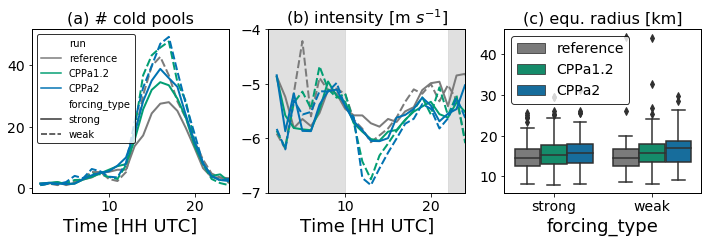

In [90]:
fig, axs = plt.subplots(ncols=3, nrows=1, sharex=False, sharey=False, figsize=[12,3.])

colors =[(0.4803921568627451, 0.4803921568627451, 0.4803921568627451),
         (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745)]

kws =dict(hue_order=['reference', 'CPPa1.2','CPPa2'], palette=colors, lw=2, style='forcing_type',ci=None)

sns.lineplot(data=df, x='leadtime', y = 'n_clusters',hue='run', ax=axs[0], **kws)
leg = axs[0].legend(loc='upper left' , ncol=1, fontsize=10)
leg.get_frame().set_alpha(0.8)
axs[0].set_title('(a) # cold pools',fontsize=16)

#sns.lineplot(data=df, x='leadtime', y = 'r_equ_mean', hue='run', estimator=np.mean,ax=axs[1], legend=False, **kws)
sns.boxplot(data=df, x='forcing_type', y = 'r_equ_mean',  hue='run',hue_order=['reference', 'CPPa1.2','CPPa2'],palette=colors, 
           ax=axs[2])
leg = axs[2].legend(loc='upper left' , ncol=1, fontsize=14)
leg.get_frame().set_alpha(0.8)
#axs[1].axvspan(-2, 10, alpha=0.7, color='lightgrey')
#axs[1].axvspan(22, 25, alpha=0.7, color='lightgrey')
axs[2].set_title('(c) equ. radius [km]',fontsize=16)
axs[2].set_ylabel('')
#axs[1].set_ylim([10,20])

sns.lineplot(data=df, x='leadtime', y = 'intensity_median', hue='run', estimator=np.mean,ax=axs[1], legend=False, **kws)
axs[1].axvspan(-2, 10, alpha=0.7, color='lightgrey')
axs[1].axvspan(22, 25, alpha=0.7, color='lightgrey')
axs[1].set_title(r'(b) intensity [m $s^{-1}$]',fontsize=16)
axs[1].set_ylim([-7,-4])

for i in range(0,2):
    axs[i].set_xlabel('Time [HH UTC]')
    axs[i].set_xlim([1,24])
    axs[i].set_ylabel('')
#    axs[i].xaxis.set_major_formatter(DateFormatter("%H"))
    #axs[i].autoscale(tight=True)
#plt.tight_layout()
figname='../Figures/Paper/detected_coldpools_statistics.pdf'
plt.savefig(figname, bbox_inches='tight')

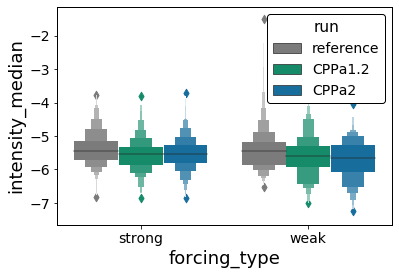

In [88]:
sns.boxenplot(data=df, x='forcing_type', y = 'intensity_median',    hue='run',hue_order=['reference', 'CPPa1.2','CPPa2'],palette=colors)

# Table

In [4]:
run='ref'
dfs=dict()
runs = ['ref', 'cppa1.2', 'cppa2.0']
for run in tqdm(runs):
    egg = pd.read_csv('/project/meteo-scratch/Christian.Sackrenz/cpp-new/tabelle_'+run+'.csv')
    egg['run']=run
    egg['forcing_type']=None
    egg.loc[egg.starttime<'2016-06-03', 'forcing_type']='strong'
    egg.loc[egg.starttime>='2016-06-03', 'forcing_type']='weak'
    egg = egg.rename(columns={'Laufstunden_h':'leadtime'},)
    dfs[run]=egg
    
df = pd.concat(dfs).reset_index()

100%|██████████| 3/3 [00:00<00:00, 15.74it/s]


In [5]:
colors =[(0.4803921568627451, 0.4803921568627451, 0.4803921568627451),
          (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
         (0.00784313725490196, 0.6196078431372549, 0.45098039215686275)]

In [6]:
df

,level_0,level_1,Unnamed: 0,Index,starttime,leadtime,radius_equ_km,intensity_mean,rain_mean,pt_rho_pert_mean,run,forcing_type
0,cppa1.2,0,0,1,2016-05-29T00:00:00.000000000,1.0,18.307528,-5.578113,4.698406,-1.559647,cppa1.2,strong
1,cppa1.2,1,1,2,2016-05-29T00:00:00.000000000,1.0,11.536050,-3.472665,10.112403,-1.552598,cppa1.2,strong
2,cppa1.2,2,2,1,2016-05-29T00:00:00.000000000,2.0,12.361071,-5.006544,2.840213,-1.286696,cppa1.2,strong
3,cppa1.2,3,3,1,2016-05-29T00:00:00.000000000,5.0,25.507166,-6.841450,0.249198,-1.979492,cppa1.2,strong
4,cppa1.2,4,4,2,2016-05-29T00:00:00.000000000,5.0,11.211025,-5.231699,26.706478,-1.546758,cppa1.2,strong
5,cppa1.2,5,5,1,2016-05-29T00:00:00.000000000,6.0,25.603602,-6.780104,1.578697,-2.014355,cppa1.2,strong
6,cppa1.2,6,6,2,2016-05-29T00:00:00.000000000,6.0,21.695863,-5.784830,0.176284,-1.542224,cppa1.2,strong
7,cppa1.2,7,7,3,2016-05-29T00:00:00.000000000,6.0,15.932314,-4.771937,10.112874,-1.441170,cppa1.2,strong
8,cppa1.2,8,8,4,2016-05-29T00:00:00.000000000,6.0,12.361071,-4.939318,1.343469,-1.354005,cppa1.2,strong
9,cppa1.2,9,9,1,2016-05-29T00:00:00.000000000,7.0,25.938303,-7.018225,0.785362,-2.286550,cppa1.2,strong


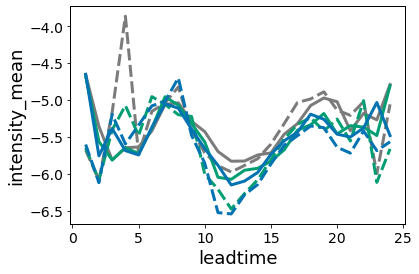

In [45]:

sns.lineplot(data=df, x = 'leadtime', y = 'intensity_mean',hue='run', style='forcing_type', ci =None, hue_order =runs, 
             legend=False, palette=colors, linewidth=3)

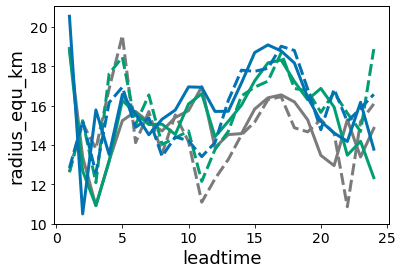

In [46]:

sns.lineplot(data=df, x = 'leadtime', y = 'radius_equ_km',hue='run', style='forcing_type', ci =None, hue_order =runs, 
             legend=False, palette=colors, linewidth=3)

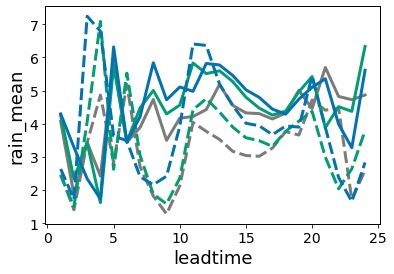

In [44]:
sns.lineplot(data=df, x = 'leadtime', y = 'rain_mean',hue='run', style='forcing_type', ci =None, hue_order =runs, 
             legend=False, palette=colors, linewidth=3)

Text(0, 0.5, '# cold pools')

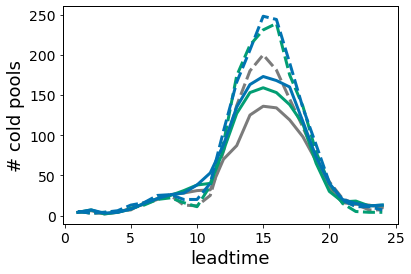

In [52]:
sns.lineplot(data=df, x = 'leadtime', y = 'rain_mean',hue='run', style='forcing_type', ci =None, hue_order =runs, estimator=np.count_nonzero,
             legend=False, palette=colors, linewidth=3)
plt.ylabel('# cold pools')

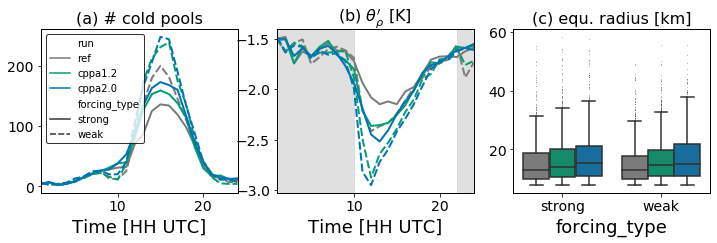

In [17]:
fig, axs = plt.subplots(ncols=3, nrows=1, sharex=False, sharey=False, figsize=[12,3.])

colors =[(0.4803921568627451, 0.4803921568627451, 0.4803921568627451),
         (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745)]

kws =dict(hue_order=runs, palette=colors, lw=2, style='forcing_type',ci=None)

sns.lineplot(data=df, x='leadtime', y = 'rain_mean',hue='run', ax=axs[0],estimator=np.count_nonzero, **kws)
leg = axs[0].legend(loc='upper left' , ncol=1, fontsize=10)
leg.get_frame().set_alpha(0.8)
axs[0].set_title('(a) # cold pools',fontsize=16)

#sns.lineplot(data=df, x='leadtime', y = 'r_equ_mean', hue='run', estimator=np.mean,ax=axs[1], legend=False, **kws)
sns.boxplot(data=df, x='forcing_type', y = 'radius_equ_km',  hue='run',hue_order=runs,palette=colors,fliersize=0.1, ax=axs[2 ])
axs[2].get_legend().remove()
#leg = axs[2].legend()#(loc='upper left' , ncol=1, fontsize=14)
#leg.get_frame().set_alpha(0.8)
#axs[1].axvspan(-2, 10, alpha=0.7, color='lightgrey')
#axs[1].axvspan(22, 25, alpha=0.7, color='lightgrey')
axs[2].set_title('(c) equ. radius [km]',fontsize=16)
axs[2].set_ylabel('')
#axs[1].set_ylim([10,20])

sns.lineplot(data=df, x='leadtime', y = 'pt_rho_pert_mean', hue='run', estimator=np.mean,ax=axs[1], legend=False, **kws)
axs[1].axvspan(-2, 10, alpha=0.7, color='lightgrey')
axs[1].axvspan(22, 25, alpha=0.7, color='lightgrey')
axs[1].set_title(r"(b) $\theta_{\rho}'$ [K]",fontsize=16)
#axs[1].set_ylim([-7,-4])

for i in range(0,2):
    axs[i].set_xlabel('Time [HH UTC]')
    axs[i].set_xlim([1,24])
    axs[i].set_ylabel('')
#    axs[i].xaxis.set_major_formatter(DateFormatter("%H"))
    #axs[i].autoscale(tight=True)
#plt.tight_layout()
figname='../Figures/Paper/detected_coldpools_statistics.pdf'
plt.savefig(figname, bbox_inches='tight')

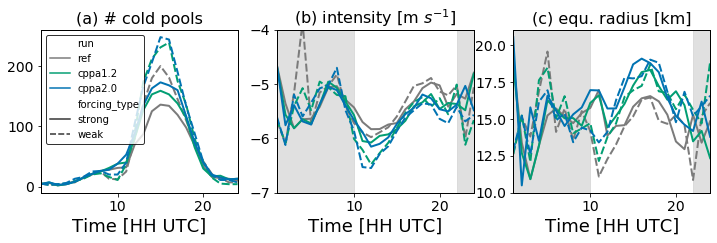

In [77]:
fig, axs = plt.subplots(ncols=3, nrows=1, sharex=False, sharey=False, figsize=[12,3.])

colors =[(0.4803921568627451, 0.4803921568627451, 0.4803921568627451),
         (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),
 (0.00392156862745098, 0.45098039215686275, 0.6980392156862745)]

kws =dict(hue_order=runs, palette=colors, lw=2, style='forcing_type',ci=None)

sns.lineplot(data=df, x='leadtime', y = 'rain_mean',hue='run', ax=axs[0],estimator=np.count_nonzero, **kws)
leg = axs[0].legend(loc='upper left' , ncol=1, fontsize=10)
leg.get_frame().set_alpha(0.8)
axs[0].set_title('(a) # cold pools',fontsize=16)

sns.lineplot(data=df, x='leadtime', y = 'radius_equ_km', hue='run', estimator=np.mean,ax=axs[2], legend=False, **kws)
#sns.boxplot(data=df, x='forcing_type', y = 'radius_equ_km',  hue='run',hue_order=runs,palette=colors,fliersize=0.1, ax=axs[2 ])
#axs[2].get_legend().remove()
#leg = axs[2].legend()#(loc='upper left' , ncol=1, fontsize=14)
#leg.get_frame().set_alpha(0.8)
axs[2].axvspan(-2, 10, alpha=0.7, color='lightgrey')
axs[2].axvspan(22, 25, alpha=0.7, color='lightgrey')
axs[2].set_title('(c) equ. radius [km]',fontsize=16)
axs[2].set_ylabel('')
#axs[1].set_ylim([10,20])

sns.lineplot(data=df, x='leadtime', y = 'intensity_mean', hue='run', estimator=np.mean,ax=axs[1], legend=False, **kws)
axs[1].axvspan(-2, 10, alpha=0.7, color='lightgrey')
axs[1].axvspan(22, 25, alpha=0.7, color='lightgrey')
axs[1].set_title(r'(b) intensity [m $s^{-1}$]',fontsize=16)
axs[1].set_ylim([-7,-4])

for i in range(0,3):
    axs[i].set_xlabel('Time [HH UTC]')
    axs[i].set_xlim([1,24])
    axs[i].set_ylabel('')
#    axs[i].xaxis.set_major_formatter(DateFormatter("%H"))
    #axs[i].autoscale(tight=True)
#plt.tight_layout()
figname='../Figures/Paper/detected_coldpools_statistics.pdf'
plt.savefig(figname, bbox_inches='tight')

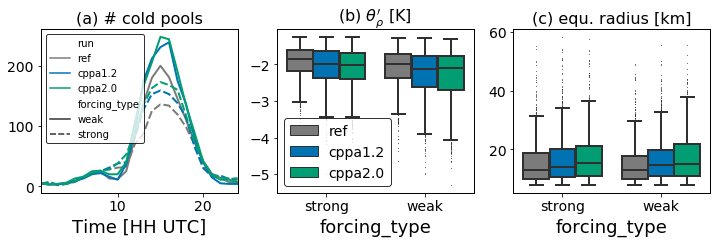

In [9]:
fig, axs = plt.subplots(ncols=3, nrows=1, sharex=False, sharey=False, figsize=[12,3.])

colors =[(0.4803921568627451, 0.4803921568627451, 0.4803921568627451),
          (0.00392156862745098, 0.45098039215686275, 0.6980392156862745),
         (0.00784313725490196, 0.6196078431372549, 0.45098039215686275),]

kws =dict(hue_order=runs, palette=colors, lw=2, style='forcing_type',ci=None)

sns.lineplot(data=df, x='leadtime', y = 'rain_mean',hue='run', ax=axs[0],estimator=np.count_nonzero, style_order = ['weak', 'strong'],**kws)
leg = axs[0].legend(loc='upper left' , ncol=1, fontsize=10)
leg.get_frame().set_alpha(0.8)
axs[0].set_title('(a) # cold pools',fontsize=16)



#sns.lineplot(data=df, x='leadtime', y = 'intensity_mean', hue='run', estimator=np.mean,ax=axs[1], legend=False, **kws)
sns.boxplot(data=df, x='forcing_type', y = 'pt_rho_pert_mean',  hue='run',hue_order=runs,palette=colors,fliersize=0.2, saturation=1,
            ax=axs[1], linewidth=2, )
#axs[1].get_legend().remove()
#axs[1].axvspan(-2, 10, alpha=0.7, color='lightgrey')
#axs[1].axvspan(22, 25, alpha=0.7, color='lightgrey')
leg = axs[1].legend(loc='lower left' , ncol=1, fontsize=14)
leg.get_frame().set_alpha(0.8)
axs[1].set_title(r"(b) $\theta_{\rho}'$ [K]",fontsize=16)
axs[1].set_ylabel('')
axs[2].set_xlabel('Forcing type')
#axs[1].set_ylim([-7,-4])

#sns.lineplot(data=df, x='leadtime', y = 'radius_equ_km', hue='run', estimator=np.mean,ax=axs[2], legend=False, **kws)
sns.boxplot(data=df, x='forcing_type', y = 'radius_equ_km',  hue='run',hue_order=runs,palette=colors,fliersize=0.2,
            ax=axs[2 ], linewidth=2, saturation=1)
axs[2].get_legend().remove()
#leg = axs[2].legend()#(loc='upper left' , ncol=1, fontsize=14)
#leg.get_frame().set_alpha(0.8)
#axs[2].axvspan(-2, 10, alpha=0.7, color='lightgrey')
#axs[2].axvspan(22, 25, alpha=0.7, color='lightgrey')

axs[2].set_title('(c) equ. radius [km]',fontsize=16)
axs[2].set_ylabel('')
#axs[2].set_xlabel('Forcing type')
#axs[1].set_ylim([10,20])

for i in range(0,1):
    axs[i].set_xlabel('Time [HH UTC]')
    axs[i].set_xlim([1,24])
    axs[i].set_ylabel('')
#    axs[i].xaxis.set_major_formatter(DateFormatter("%H"))
    #axs[i].autoscale(tight=True)
#plt.tight_layout()
figname='../Figures/Paper/detected_coldpools_statistics.pdf'
plt.savefig(figname, bbox_inches='tight')

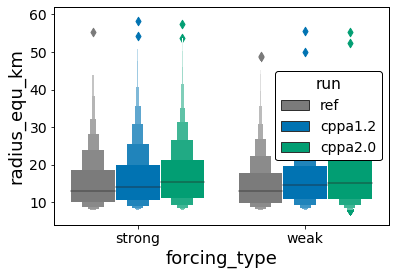

In [10]:
sns.boxenplot(data=df, x='forcing_type', y = 'radius_equ_km',  hue='run',hue_order=runs,palette=colors,
             linewidth=2, saturation=1)